# Summer School on Biomedical Imaging with Deep Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/albarqounilab/BILD-Summer-School/blob/main/notebooks/day1/cnn_classification.ipynb)

![alt_text](https://raw.githubusercontent.com/albarqounilab/BILD-Summer-School/refs/heads/main/images/helpers/notebook-banner.png)

BILD 2025 is organized under the umbrella of the [Strategic Arab-German Network for Affordable and Democratized AI in Healthcare (SANAD)](https://albarqouni.github.io/funded/sanad/), uniting academic excellence and technological innovation across borders. This year’s edition is organized by the [Albarqouni Lab](https://albarqouni.github.io/) at the [University Hospital Bonn](https://www.ukbonn.de/) and the [University of Bonn](https://www.uni-bonn.de/en). We are proud to partner with leading institutions in the region—Lebanese American University, University of Tunis El Manar, and Duhok Polytechnic University — to deliver a truly international learning experience. Over five intensive days in Tunis, you will explore cutting-edge deep-learning techniques for medical imaging through expert lectures, hands-on labs, and collaborative case studies. Engage with peers and faculty from Germany, Lebanon, Iraq, and Tunisia as you develop practical skills in building and deploying AI models for real-world healthcare challenges. We look forward to an inspiring week of interdisciplinary exchange and the shared commitment to advancing affordable, life-saving AI in medicine.


## Chest-X-Ray Classification and Detection [60 mins]

### Introduction

This notebook will guide you step-by-step through practical exercises on using Convolutional Neural Networks (CNNs) for classifying and detecting diseases in chest X-ray images. If you are new to machine learning, PyTorch, or Python, don't worry—each section will explain what is happening and why it is important.

We will use two real-world chest X-ray datasets to learn how to:
- Recognize (classify) if a chest X-ray shows signs of disease or is healthy.
- Find (detect) the location of disease in the image using bounding boxes.

**Why do we do this?**
- Medical images like X-rays are used by doctors to diagnose diseases. Automating this process with AI can help doctors make faster and more accurate decisions.

**The datasets:**
- **NIH ChestX-ray14:** Over 100,000 X-ray images labeled with 14 different diseases. Some images also have boxes showing where the disease is located.
- **RSNA Pneumonia Detection Challenge:** About 30,000 X-rays with expert-drawn boxes around pneumonia, perfect for learning detection.

**What will you learn?**
1. **How to work with medical image datasets.**
   - Loading images and reading their labels (what disease, if any, is present).
   - Understanding the structure of the data and why we split it into training, validation, and test sets.
2. **How to build and train a model to classify images.**
   - Using powerful pre-trained models and adapting them to our problem.
   - Measuring how well our model is doing and how to improve it.
3. **How to detect disease locations in images.**
   - Using models that can draw boxes around areas of interest.
   - Evaluating how accurate these detections are.
4. **How to report and interpret results.**
   - Understanding key metrics like accuracy and ROC-AUC.
   - Visualizing results to see what the model got right and wrong.

By the end of this notebook, you will have hands-on experience with the full process of building, training, and evaluating deep learning models for medical image analysis, even if you are just starting out!

## Dataset

The [NIH ChestX-ray-14](https://nihcc.app.box.com/v/ChestXray-NIHCC) dataset is a large collection of chest X-ray images. Each image comes with information about the patient and labels that tell us which diseases (if any) are present. This dataset is widely used in medical AI research because it helps us train and test models to recognize diseases from X-ray images.

**What does the dataset contain?**
1. Over 100,000 chest X-ray images, each in PNG format. These are pictures of the inside of the chest, showing the lungs and heart.
2. A metadata file (`Data_Entry_2017.csv`) that lists information about each image, such as:
   - Which diseases are present (if any)
   - Patient age and gender
   - How the image was taken
3. A file with bounding boxes (`BBox_List_2017.csv`) for about 1,000 images. These boxes show exactly where a disease is located in the image.
4. Files that split the data into training and test sets. This is important because we want to train our model on some images and test it on others to see how well it works on new data.

**Why do we use this dataset?**
- It is large and diverse, which helps our model learn better.
- It has real medical labels, making our project more realistic.
- It allows us to practice both classification (is there a disease?) and detection (where is the disease?).

In this notebook, we will use a smaller sample of this dataset and pre-trained models to make the exercises faster and easier to follow.

In [ ]:
# Download data from Hugging Face
!pip install -q huggingface_hub
from huggingface_hub import hf_hub_download
import os

DATA_PATH = './Classification'
REPO_ID = 'albarqouni/bild-dataset/Classification'
os.makedirs(DATA_PATH, exist_ok=True)

# Download csv.zip
csv_zip_path = hf_hub_download(
    repo_id=REPO_ID,
    repo_type="dataset",
    filename="csv.zip",
    local_dir=DATA_PATH
)

# Download data_cxr8.zip
data_zip_path = hf_hub_download(
    repo_id=REPO_ID,
    repo_type="dataset",
    filename="data_cxr8.zip",
    local_dir=DATA_PATH
)

print("Download complete.")

In [ ]:
!unzip -q {DATA_PATH}/csv.zip -d {DATA_PATH}
!unzip -q {DATA_PATH}/data_cxr8.zip -d {DATA_PATH}

In [ ]:
# RSNA dataset download is not included in the Hugging Face Classification dataset.
# If needed, add similar Hugging Face download logic here for RSNA or other datasets.

# Classification

## Import essentials

In [ ]:
#@title import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

!pip install pydicom -q
import pydicom

!pip install SimpleITK -q
import SimpleITK as sitk

from glob import glob
import time
import cv2
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import tv_tensors
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import pydicom # Added import for pydicom

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

from torchvision import transforms, models
from PIL import Image
import random
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import OneCycleLR

from sklearn.metrics import accuracy_score
from torchmetrics.classification import BinaryAUROC

### Download

Before we can work with the data, we need to download and unzip it. This means we are copying the files from the internet to our computer and making them ready to use.

**Why do we do this?**
- Machine learning models need data to learn from. Downloading the dataset gives us the images and labels we need for our project.
- Unzipping extracts the files from a compressed format so we can access them easily in our code.

**Instructions:**
- If you have not downloaded the dataset yet, run the following cells to download and unzip the files.
- If you already have the data, you can skip these steps by adding a `#` before the `!` in the code (this comments out the line so it won't run).
- You can also change the `DATA_PATH` variable if you want to store the data in a different folder.

> **Tip:** Downloading large datasets can take a while, depending on your internet speed.

In [ ]:
# Download pretrained model weights from Hugging Face
from huggingface_hub import hf_hub_download

# DenseNet121
hf_hub_download(
    repo_id=REPO_ID,
    repo_type="dataset",
    filename="densenet121-classification.pth",
    local_dir="."
)
# EfficientNet
hf_hub_download(
    repo_id=REPO_ID,
    repo_type="dataset",
    filename="efficientnet-classification.pth",
    local_dir="."
)
# Swin Transformer
hf_hub_download(
    repo_id=REPO_ID,
    repo_type="dataset",
    filename="swintransformer-classification.pth",
    local_dir="."
)
print("Model weights downloaded.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1436k  100 1436k    0     0  4688k      0 --:--:-- --:--:-- --:--:-- 4678k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  424k  100  424k    0     0  1544k      0 --:--:-- --:--:-- --:--:-- 1545k


### Load patient splits

To train and evaluate our model properly, we need to split our data into different groups:
- **Training set:** Used to teach the model.
- **Validation set:** Used to check how well the model is learning during training.
- **Test set:** Used to see how well the model works on completely new data.

In this step, we load lists of which images belong to each group. This helps us make sure that the model is tested on images it has never seen before, which is important for getting a fair measure of its performance.

In [ ]:
train_val_patients = pd.read_csv(f'{DATA_PATH}/train_val_list.txt', header=None, names=['patientId'])
test_patients = pd.read_csv(f'{DATA_PATH}/test_list.txt', header=None, names=['patientId'])

print(f"Number of patients in train/val set: {len(train_val_patients)}")
print(f"Number of patients in test set: {len(test_patients)}")

Number of patients in train/val set: 86524
Number of patients in test set: 25596


The `.txt` files contain lists of image names that belong to the training/validation or test sets. To use these splits, we need to match the image names in these files with the information in our main database (`metadata.csv`). This way, we know which images and labels go into each group for training and testing.

### Load dataframe metadata

A **dataframe** is a table of data, like a spreadsheet, that we can easily work with in Python using the pandas library. Here, we load the metadata for all our images. This metadata tells us important information about each image, such as which diseases are present, the patient ID, and more. Loading this information helps us organize and prepare our data for training and testing our model.

In [ ]:
# Load and observe available data
metadata_df = pd.read_csv(f'{DATA_PATH}/metadata.csv')
metadata_df#.head() # Print the 5 fist rows of the dataframe

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Sex,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,38,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168


Now we need to make sure that the information in our dataframe matches the images we actually downloaded. This step filters out any entries in the metadata that do not have a corresponding image file, so we only work with images that are available on our computer.

In [ ]:
imgs = glob(f'{DATA_PATH}/images/*')
imgs_basename = [os.path.basename(i) for i in imgs]

metadata_df = metadata_df.loc[metadata_df['Image Index'].isin(imgs_basename)]
metadata_df.shape

(92120, 11)

### Handle targets

In machine learning, a **target** is what we want the model to predict. For this project, the target is the disease label for each image. In this step, we prepare the target labels so that our model can learn to predict them. This may involve simplifying the labels or grouping them in a way that makes the problem easier to solve.

In the next step, we look at how many times each disease label appears in our data. Some diseases are very rare, which can make it hard for the model to learn about them. To keep things simple and make sure our model has enough examples to learn from, we will remove labels that appear less than 1,500 times.

In [ ]:
label_counts = metadata_df['Finding Labels'].value_counts()
label_counts

Finding Labels
No Finding                                                        49553
Infiltration                                                       8099
Atelectasis                                                        3491
Effusion                                                           3139
Nodule                                                             2259
                                                                  ...  
Atelectasis|Consolidation|Edema|Effusion|Pneumonia                    1
Cardiomegaly|Effusion|Fibrosis|Mass                                   1
Cardiomegaly|Edema|Effusion|Fibrosis|Hernia                           1
Consolidation|Effusion|Emphysema|Infiltration                         1
Atelectasis|Consolidation|Mass|Pleural_Thickening|Pneumothorax        1
Name: count, Length: 777, dtype: int64

We remove rare labels (diseases that appear in fewer than 1,500 images) so that our model has enough examples to learn from. This helps the model focus on the most common diseases and improves its ability to make accurate predictions.

After filtering out rare labels, we are left with the most common disease categories. The table below shows how many images belong to each label. This helps us understand the balance of our dataset and which diseases our model will learn to recognize.

First, we look at how many images there are for each disease label. This helps us see if some diseases are much more common than others, which can affect how well our model learns.

In [ ]:
label_counts = metadata_df['Finding Labels'].value_counts()
rare_labels = label_counts[label_counts < 1500].index

Now we update our data table (DataFrame) to remove any images with rare disease labels. This makes sure our model only sees images with the most common labels, which helps it learn better.

In [ ]:
metadata_df_filtered = metadata_df[~metadata_df['Finding Labels'].isin(rare_labels)].copy()

print(f"Original shape: {metadata_df.shape}")
print(f"Filtered shape: {metadata_df_filtered.shape}")

Original shape: (92120, 11)
Filtered shape: (70117, 11)


In [ ]:
metadata_df_filtered['Finding Labels'].value_counts()

Finding Labels
No Finding      49553
Infiltration     8099
Atelectasis      3491
Effusion         3139
Nodule           2259
Pneumothorax     1848
Mass             1728
Name: count, dtype: int64

To make our task easier, we will turn the problem into a **binary classification** problem. This means the model will learn to answer a simple question: Is this X-ray healthy or does it show signs of disease?

- **Class 0 (Negative):** Images labeled as 'No Finding' (healthy)
- **Class 1 (Positive):** Images with any disease label (pathology present)

This approach is common in deep learning when starting out, because it is easier for the model to learn to distinguish between just two categories. The category we want the model to predict is called the **target class**. Here, you can also try focusing on a specific disease (like 'Effusion') or experiment with more classes to see how the model behaves.

In [ ]:
keep = {
    'No Finding', 'Effusion',
}

# split each cell into a list, then keep rows where at least one element is in `keep`
df_filtered = metadata_df_filtered[
    metadata_df_filtered['Finding Labels']
      .str.split('|')                         # or .str.split(',') if comma‑separated
      .apply(lambda labels: any(lbl in keep for lbl in labels))
].copy()
df_filtered['Finding Labels'].value_counts()

Finding Labels
No Finding    49553
Effusion       3139
Name: count, dtype: int64

Now we create a new column called `Binary Label` in our data. This column will have a value of 0 for healthy images and 1 for images with any disease. This process is called **label encoding** and is very common in deep learning, because models work best with numbers instead of text.

In [ ]:
df_filtered['Binary Label'] = (df_filtered['Finding Labels'] != 'No Finding').astype(int)
df_filtered['Binary Label'].value_counts()

Binary Label
0    49553
1     3139
Name: count, dtype: int64

We can further clean our dataset by selecting only one **view acquisition** type for our classifier. 'View acquisition' refers to the way the X-ray image was taken (for example, from the front or the side). Using only one type (like 'PA' for posteroanterior) helps the model learn more consistently, because all images will look similar in terms of orientation.

In [ ]:
df_filtered = df_filtered[df_filtered["View Position"] == 'PA']
df_filtered['View Position'].value_counts()

View Position
PA    34135
Name: count, dtype: int64

Now we use the lists of patient IDs to split our data into a **training set** (used to teach the model) and a **test set** (used to check how well the model works on new, unseen data). This is called a **train-test split** and is a key step in building reliable machine learning models.

In [ ]:
# Split df_filtered based on patient IDs from the loaded lists
train_val_df = df_filtered[df_filtered['Image Index'].isin(train_val_patients['patientId'])].copy()
test_df = df_filtered[df_filtered['Image Index'].isin(test_patients['patientId'])].copy()

print(f"Train val shape: {train_val_df.shape}")
print(f"Test set shape: {test_df.shape}")

Train val shape: (29674, 12)
Test set shape: (4461, 12)


### Deep Learning Data Terminology

- **Batch:** A batch is a small group of samples processed together by the model before updating its parameters. Using batches makes training faster and more stable.
- **Epoch:** One epoch means the model has seen all the training data once. Training usually takes many epochs.
- **DataLoader:** In PyTorch, a DataLoader helps us load data in batches, shuffle it, and use multiple CPU cores to speed up the process. This is essential for efficient deep learning training.

In [ ]:
df = train_val_df.copy()
pos = df[df['Binary Label'] == 1]
neg = df[df['Binary Label'] == 0]

# # sample up to x each
n_samples = 3000
pos = pos.sample(n=min(len(pos), n_samples), random_state=42)
neg = neg.sample(n=min(len(neg), n_samples), random_state=42)

subset = pd.concat([pos, neg]).reset_index(drop=True)
print("Subset size:", subset.shape)
print(subset['Binary Label'].value_counts())

# %%
train_validation_df, test_df = train_test_split(
    subset,
    test_size=0.2,
    stratify=subset['Binary Label'],
    random_state=42
)
train_df, val_df = train_test_split(
    train_validation_df,
    test_size=0.1,
    stratify=train_validation_df['Binary Label'],
    random_state=42
)
print("Train:", train_df.shape, "Validation:", val_df.shape)

Subset size: (4284, 12)
Binary Label
0    3000
1    1284
Name: count, dtype: int64
Train: (3084, 12) Validation: (343, 12)


### Download the pretrained model


This week, we delve into the power of deep models like CNNs, leveraging the PyTorch library as our framework. PyTorch provides the flexibility and tools necessary to explore and implement these complex architectures for challenging tasks.

### Datasets in PyTorch
Next we define our custom `ChestXrayDataset` using torch `Dataset` from `torch.utils.data`

In [ ]:
class ChestXrayDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['Image Index'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(row['Binary Label'], dtype=torch.float32)
        return image, label

**Transforms** are changes we make to images as we load them. This can include resizing, flipping, rotating, or normalizing the images. When we do these changes randomly during training, it is called **data augmentation**. Data augmentation helps the model learn to recognize patterns in different situations, making it more robust and less likely to memorize the training data (a problem called overfitting).

In [ ]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

image_size_= 224

train_transforms = transforms.Compose([
    transforms.Resize((image_size_,image_size_)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


Now the `val_transforms`

In [ ]:
val_transforms   = transforms.Compose([
    transforms.Resize((image_size_,image_size_)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

### Dataloaders

A **DataLoader** is a tool in PyTorch that helps us load data in small groups called **mini-batches**. Instead of giving the model one image at a time, we give it a batch of images. This makes training faster and helps the model learn more stable patterns. Dataloaders also make it easy to shuffle the data and use multiple CPU cores for loading.

In [ ]:
img_dir  = f'{DATA_PATH}/images'

train_ds = ChestXrayDataset(train_df, img_dir, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=90, pin_memory=True)

We pass the `Dataset` as an argument to `DataLoader`. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 32, *i.e.* each element in the dataloader iterable will return a batch of 32 features and labels.

In [ ]:
for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.float32


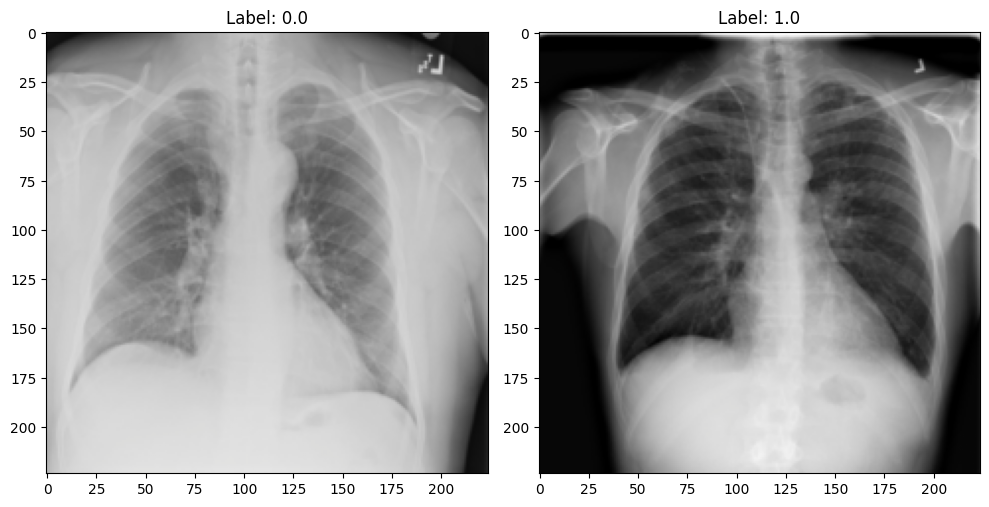

In [ ]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

In [ ]:
val_ds   = ChestXrayDataset(val_df,   img_dir, transform=val_transforms)
val_loader   = DataLoader(val_ds,   batch_size=32, num_workers=32, pin_memory=True)

## Loading pretrained models with PyTorch

A **pretrained model** is a model that has already been trained on a large dataset (like ImageNet) and has learned useful features. The structure of the model is called its **architecture** (for example, DenseNet, ResNet, EfficientNet). Using a pretrained model and adapting it to our own data is called **transfer learning**. This is very helpful because it allows us to get good results even with smaller datasets and less training time.
In 'torchvision.models' we can find many popular pretrained models and architectures.

In [ ]:
torchvision.models.list_models()

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 1)
model = model.to(device)
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Hyperparameters

**Hyperparameters** are settings that you choose before training your model. They control how the learning process works. Common hyperparameters include:
- **Number of epochs:** How many times the model sees the whole training set.
- **Batch size:** How many samples are in each batch.
- **Learning rate:** How big the steps are when updating the model's weights.

Tuning hyperparameters is important because it can make a big difference in how well your model learns.

In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 10

### Optimization loop

Training a deep learning model involves an **optimization loop**. Each time the model sees the whole training set, it completes one **epoch**. The process has two main parts:
- **Train loop:** The model learns from the training data and updates its parameters.
- **Validation loop:** The model is tested on validation data to see how well it is learning.

A **loss function** measures how far the model's predictions are from the true answers. The goal of training is to minimize this loss. The optimization loop repeats for many epochs until the model performs well.

In [ ]:
pos_frac = train_df['Binary Label'].mean()
pos_weight = torch.tensor([(1 - pos_frac) / pos_frac]).to(device)

criterion  = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

Inside the training loop, the model learns by adjusting its parameters using **gradients**. Gradients show how much each parameter should change to reduce the loss. The process of calculating gradients and updating parameters is called **backpropagation**.

- **optimizer.zero_grad():** Resets the gradients to zero before each batch.
- **loss.backward():** Calculates the gradients using backpropagation.
- **optimizer.step():** Updates the model's parameters using the gradients.
- **Learning rate scheduler (like OneCycleLR):** Adjusts the learning rate during training to help the model learn better and faster.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(optimizer, max_lr=learning_rate, epochs=epochs, steps_per_epoch=len(train_loader), total_steps=epochs * len(train_loader))

Next, we define our **training function** and **validation function**. The training function teaches the model using the training data, while the validation function checks how well the model is doing on data it hasn't seen before. Keeping these functions separate helps us monitor the model's progress and avoid overfitting (when the model memorizes the training data but doesn't generalize well to new data).

In [ ]:
def train_loop(model, loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    for imgs, labels in tqdm(loader, desc="  Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs).squeeze(1)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        try:
            scheduler.step()
        except ValueError:
            pass

        running_loss += loss.item() * imgs.size(0)

    avg_loss = running_loss / len(loader.dataset)
    return avg_loss


def val_loop(model, loader, criterion, auroc, device):
    model.eval()
    auroc.reset()
    running_preds = []
    running_labels = []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="  Validation", leave=False):
            imgs = imgs.to(device)
            logits = model(imgs).squeeze(1)
            probs = torch.sigmoid(logits)

            preds = (probs > 0.5).int().cpu().numpy()
            running_preds.extend(preds.tolist())
            running_labels.extend(labels.int().tolist())

            auroc.update(probs, labels.int().to(device))

    acc = accuracy_score(running_labels, running_preds)
    val_auroc = auroc.compute().item()
    return acc, val_auroc


In [ ]:

img_dir  = f'{DATA_PATH}/images'

train_ds = ChestXrayDataset(train_df, img_dir, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=90, pin_memory=True)

val_ds   = ChestXrayDataset(val_df,   img_dir, transform=val_transforms)
val_loader   = DataLoader(val_ds,   batch_size=32, num_workers=32, pin_memory=True)

auroc = BinaryAUROC().to(device)

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    train_loss = train_loop(model, train_loader, criterion, optimizer, scheduler, device)
    val_acc, val_auroc = val_loop(model, val_loader, criterion, auroc, device)

    print(f"  Train Loss: {train_loss:.4f}  |  Val Acc: {val_acc:.4f}  |  Val AUROC: {val_auroc:.4f}")

Epoch 1/10


  Train Loss: 0.7583  |  Val Acc: 0.8076  |  Val AUROC: 0.8582
Epoch 2/10


  Train Loss: 0.5954  |  Val Acc: 0.4781  |  Val AUROC: 0.8813
Epoch 3/10


  Train Loss: 0.5755  |  Val Acc: 0.4461  |  Val AUROC: 0.8771
Epoch 4/10


  Train Loss: 0.5728  |  Val Acc: 0.8192  |  Val AUROC: 0.8544
Epoch 5/10


  Train Loss: 0.5282  |  Val Acc: 0.8513  |  Val AUROC: 0.8993
Epoch 6/10


  Train Loss: 0.4742  |  Val Acc: 0.8455  |  Val AUROC: 0.8873
Epoch 7/10


  Train Loss: 0.4415  |  Val Acc: 0.8192  |  Val AUROC: 0.8982
Epoch 8/10


  Train Loss: 0.3718  |  Val Acc: 0.8455  |  Val AUROC: 0.8870
Epoch 9/10


  Train Loss: 0.3135  |  Val Acc: 0.8309  |  Val AUROC: 0.8946
Epoch 10/10


  Train Loss: 0.2677  |  Val Acc: 0.8367  |  Val AUROC: 0.8949


In [ ]:
# Save the trained model
torch.save(model.state_dict(), './densenet121-classification.pth')
print("Model saved successfully!")

Model saved successfully!


### Benchmarking model architectures

A **CNN architecture** is the specific design or structure of a convolutional neural network. Different architectures (like ResNet, DenseNet, EfficientNet, Swin Transformer) use different building blocks:
- **Skip connections:** Allow information to skip layers, helping very deep networks learn better (used in ResNet).
- **Dense connections:** Connect each layer to every other layer in a block, improving information flow (used in DenseNet).
- **Normalization layers:** Help stabilize and speed up training by keeping the data flowing through the network at a similar scale.

Trying different architectures is important because some may work better for your specific problem. In this section, you will train and compare several architectures to see which performs best on your data.

<div class="alert alert-block alert-info">
<b>Q3.</b> In deep learning, different **model architectures** can have a big impact on performance. Complete the following cells to train and compare these models:
    - EfficientNet
    - Swin Transformer
</div>

Comparing different models helps you understand which design works best for your specific task and data.

### EfficientNet

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_enb0 = ... # COMPLETE
model_enb0.classifier[1] = nn.Linear(1280, 1)

model = ... # COMPLETE to device
print(model)

learning_rate = ... # COMPLETE
batch_size = ... # COMPLETE
epochs = ... # COMPLETE

pos_frac = train_df['Binary Label'].mean()
pos_weight = torch.tensor([(1 - pos_frac) / pos_frac]).to(device)
criterion  = ... # COMPLETE

optimizer = ... # COMPLETE
scheduler = OneCycleLR(optimizer, max_lr=learning_rate, epochs=epochs, steps_per_epoch=len(train_loader), total_steps=epochs * len(train_loader)) # Explicitly set total_steps

img_dir  = f'{DATA_PATH}/images'

train_ds = ChestXrayDataset(train_df, img_dir, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=90, pin_memory=True)

val_ds   = ChestXrayDataset(val_df,   img_dir, transform=val_transforms)
val_loader   = DataLoader(val_ds,   batch_size=32, num_workers=32, pin_memory=True)

auroc = BinaryAUROC().to(device)

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    train_loss = train_loop(model, train_loader, criterion, optimizer, scheduler, device)
    val_acc, val_auroc = val_loop(model, val_loader, criterion, auroc, device)

    print(f"  Train Loss: {train_loss:.4f}  |  Val Acc: {val_acc:.4f}  |  Val AUROC: {val_auroc:.4f}")

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

  Train Loss: 0.8551  |  Val Acc: 0.7522  |  Val AUROC: 0.8459
Epoch 2/10


  Train Loss: 0.5895  |  Val Acc: 0.6939  |  Val AUROC: 0.8797
Epoch 3/10


  Train Loss: 0.5616  |  Val Acc: 0.8251  |  Val AUROC: 0.8970
Epoch 4/10


  Train Loss: 0.5101  |  Val Acc: 0.8484  |  Val AUROC: 0.8949
Epoch 5/10


  Train Loss: 0.4756  |  Val Acc: 0.8513  |  Val AUROC: 0.9066
Epoch 6/10


  Train Loss: 0.4218  |  Val Acc: 0.8280  |  Val AUROC: 0.9094
Epoch 7/10


  Train Loss: 0.3758  |  Val Acc: 0.8338  |  Val AUROC: 0.9074
Epoch 8/10


  Train Loss: 0.3038  |  Val Acc: 0.8513  |  Val AUROC: 0.9156
Epoch 9/10


  Train Loss: 0.2492  |  Val Acc: 0.8426  |  Val AUROC: 0.9142
Epoch 10/10


  Train Loss: 0.2312  |  Val Acc: 0.8513  |  Val AUROC: 0.9153


Save the trained model

In [ ]:
torch.save(model.state_dict(), './efficientnet-classification.pth')
print("Model saved successfully!")

Model saved successfully!


### SwinTransformer

In [ ]:
from torchvision.models import swin_t, Swin_T_Weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_swin = ... # COMPLETE
model_swin.head = nn.Linear(in_features=768, out_features=1, bias=True)
model = ... # COMPLETE to device
print(model)

learning_rate = ... # COMPLETE
batch_size = ... # COMPLETE
epochs = ... # COMPLETE

pos_frac = train_df['Binary Label'].mean()
pos_weight = torch.tensor([(1 - pos_frac) / pos_frac]).to(device)
criterion  = ... # COMPLETE

optimizer = ... # COMPLETE
scheduler = OneCycleLR(optimizer, max_lr=learning_rate, epochs=epochs, steps_per_epoch=len(train_loader), total_steps=epochs * len(train_loader)) # Explicitly set total_steps

img_dir  = f'{DATA_PATH}/CXR8/images'

train_ds = ChestXrayDataset(train_df, img_dir, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=90, pin_memory=True)

val_ds   = ChestXrayDataset(val_df,   img_dir, transform=val_transforms)
val_loader   = DataLoader(val_ds,   batch_size=32, num_workers=32, pin_memory=True)

auroc = BinaryAUROC().to(device)

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    train_loss = train_loop(model, train_loader, criterion, optimizer, scheduler, device)
    val_acc, val_auroc = val_loop(model, val_loader, criterion, auroc, device)

    print(f"  Train Loss: {train_loss:.4f}  |  Val Acc: {val_acc:.4f}  |  Val AUROC: {val_auroc:.4f}")

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(
       

  Train Loss: 0.7774  |  Val Acc: 0.7668  |  Val AUROC: 0.8487
Epoch 2/10


  Train Loss: 0.7689  |  Val Acc: 0.8105  |  Val AUROC: 0.8488
Epoch 3/10


  Train Loss: 0.7750  |  Val Acc: 0.8047  |  Val AUROC: 0.8429
Epoch 4/10


  Train Loss: 0.7090  |  Val Acc: 0.8017  |  Val AUROC: 0.8656
Epoch 5/10


  Train Loss: 0.6766  |  Val Acc: 0.8047  |  Val AUROC: 0.8402
Epoch 6/10


  Train Loss: 0.6341  |  Val Acc: 0.8192  |  Val AUROC: 0.8655
Epoch 7/10


  Train Loss: 0.5643  |  Val Acc: 0.8338  |  Val AUROC: 0.8927
Epoch 8/10


  Train Loss: 0.5432  |  Val Acc: 0.8367  |  Val AUROC: 0.8938
Epoch 9/10


  Train Loss: 0.5116  |  Val Acc: 0.8222  |  Val AUROC: 0.8855
Epoch 10/10


  Train Loss: 0.4928  |  Val Acc: 0.8192  |  Val AUROC: 0.8867


Save the trained model

In [ ]:
torch.save(model.state_dict(), './swintransformer-classification.pth')
print("Model saved successfully!")

Model saved successfully!


#### Metrics

After training, we need to measure how well our models perform. In deep learning, we use different **metrics** to evaluate models:
- **Accuracy:** The percentage of correct predictions.
- **Precision:** Of all the images the model said had disease, how many actually did?
- **Recall:** Of all the images that really had disease, how many did the model find?
- **F1-score:** A balance between precision and recall.
- **ROC curve:** A plot that shows how well the model separates healthy from diseased images at different thresholds.

Using multiple metrics gives a more complete picture of model performance, especially when the data is imbalanced.

<div class="alert alert-block alert-info">
<b>Q4.</b> Compare the performance of the different models using these metrics:
    - Plot the **ROC curve**
    - Accuracy score
    - Precision and Recall
    - F1-score
</div>

Comparing models with these metrics helps you choose the best one for your task.

Load the saved models

In [ ]:
model_densenet = ... # COMPLETE
model_densenet.classifier = ... # COMPLETE

model_enb0 = ... # COMPLETE
model_enb0.classifier[1] = ... # COMPLETE

model_swin = ... # COMPLETE
model_swin.head = ... # COMPLETE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_densenet.load_state_dict(torch.load('... # COMPLETE))
model_enb0.load_state_dict(torch.load('.... # COMPLETE))
model_swin.load_state_dict(torch.load('.... # COMPLETE))


<All keys matched successfully>

Now lets compute the metrics and plot all models:

Model: DenseNet 121
  Accuracy : 0.8693
  Precision: 0.7544
  Recall   : 0.8366
  F1-score : 0.7934
  ROC AUC  : 0.9158
------------------------------
Model: EfficientNet B0
  Accuracy : 0.8623
  Precision: 0.7324
  Recall   : 0.8521
  F1-score : 0.7878
  ROC AUC  : 0.9141
------------------------------
Model: Swin Transformer
  Accuracy : 0.8576
  Precision: 0.7288
  Recall   : 0.8366
  F1-score : 0.7790
  ROC AUC  : 0.9101
------------------------------


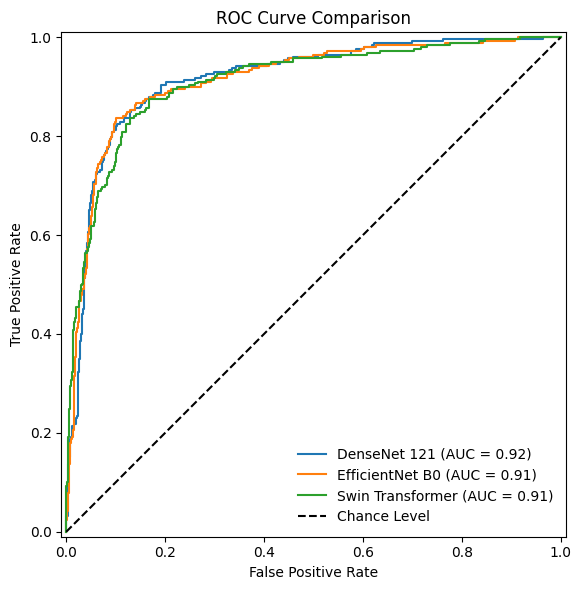

In [ ]:
test_ds     = ChestXrayDataset(test_df, img_dir, transform=val_transforms)
test_loader = DataLoader(
    test_ds,
    batch_size=32,
    num_workers=32,
    pin_memory=True,
    shuffle=False
)

model_list  = [model_densenet, model_enb0, model_swin]
model_names = ['DenseNet 121', 'EfficientNet B0', 'Swin Transformer']

all_preds_proba = {}
all_labels      = None

for model, name in zip(model_list, model_names):
    model.eval()
    model.to(device)

    probs_list, labels_list = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            out = model(X)
            probs = torch.sigmoid(out)
            probs = probs.squeeze(1)
            probs_list.extend(probs.cpu().numpy())
            labels_list.extend(y.numpy())

    preds_proba = np.array(probs_list)
    labels      = np.array(labels_list)

    all_preds_proba[name] = preds_proba
    if all_labels is None:
        all_labels = labels

    preds_binary = (preds_proba > 0.5).astype(int)

    acc     = ... # COMPLETE
    prec    = ... # COMPLETE
    rec     = ... # COMPLETE
    f1      = ... # COMPLETE
    roc_auc = ... # COMPLETE)

... # COMPLETE WITH ROC Curve display, and other metrics


### Summary: Key Deep Learning Terms

- **Dataset:** The collection of images and labels we use to train and test our model.
- **Label:** The answer we want the model to predict (e.g., healthy or diseased).
- **Model architecture:** The design or structure of the neural network.
- **Training:** Teaching the model using known data.
- **Validation:** Checking the model's performance during training.
- **Test set:** Data the model has never seen, used to measure final performance.
- **Batch/Epoch:** Groups of data and full passes through the dataset.
- **Loss function:** Measures how wrong the model's predictions are.
- **Optimizer:** Algorithm that updates the model's parameters to reduce loss.
- **Metric:** A way to measure how well the model is doing.

Reflect on these terms as you work through the notebook—they are the foundation of deep learning!

# Detection


Now that we have seen how to perform classification, we will train a detection model.
In classification, our goal was simply to assign a single label to the entire input (e.g., “normal” vs. “pneumonia”), relying on feature
extractors like ResNet or EfficientNet to encode global image cues. By contrast, detection requires both identifying and localizing multiple regions of interest—such as nodules, organs, or lesions—within a single image.

We will use the dataset from the [RSNA Pneumonia Detection Challenge](https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge/overview).

In this challenge competitors are predicting whether pneumonia exists in a given image. They do so by predicting bounding boxes around areas of the lung. Samples without bounding boxes are negative and contain no definitive evidence of pneumonia. Samples with bounding boxes indicate evidence of pneumonia.

When making predictions, competitors should predict as many bounding boxes as they feel are necessary, in the format:
confidence x-min y-min width height

All provided images are in DICOM format. Data fields availables in the `labels.csv` file are the following:
* patientId _- A patientId. Each patientId corresponds to a unique image.
* x_ - the upper-left x coordinate of the bounding box.
* y_ - the upper-left y coordinate of the bounding box.
* width_ - the width of the bounding box.
* height_ - the height of the bounding box.
* Target_ - the binary Target, indicating whether this sample has evidence of pneumonia.

In [ ]:
from torchvision.utils import draw_bounding_boxes
!pip install pycocotools
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")
import utils
from engine import train_one_epoch, evaluate

For detection, `Dataset` classes must be constructed differently. Observe the following one:

In [ ]:
class PredictionDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['patientId'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['patientId'] == image_id]

        image_dicom = pydicom.dcmread(f'{self.image_dir}/{image_id}.dcm')
        image = image_dicom.pixel_array
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB).astype(np.float32)
        image /= 255.0
        image = np.transpose(image, (2, 0, 1))
        image = tv_tensors.Image(image)
        # Define the transform
        resize_transform = torchvision.transforms.Resize((256, 256))
        # Apply the transform
        resized_img = resize_transform(image)

        boxes = records[['x', 'y', 'width', 'height']].values
        boxes[:,2] = boxes[:,0] + boxes[:,2]
        boxes[:,3] = boxes[:,1] + boxes[:,3]

        area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=(1024,1024)).float()
        target['labels'] = labels
        target['patientId'] = torch.tensor([index]).float()
        target['area'] = area.float()
        target['iscrowd'] = iscrowd

        if self.transforms:
            image, target = self.transforms(image, target)

        return image.float(), target

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In our dataset, we have both healthy and pneumonia samples. For classification, we needed to use both. But for detection, we need to filter the dataset to only keep pneumonia samples, as the healthy ones don't have any bounding box labels.

<div class="alert alert-block alert-info">
<b>Q5.</b> Explore the structure of the labels with bounding boxes. How many positive samples (with pneumonia) are in the dataset? What proportion of images contain multiple bounding boxes?
</div>

In [ ]:
# N. of positive samples
positive_samples = ... # COMPLETE
total_samples = ... # COMPLETE
print(f"Positive cases: {positive_samples} / {total_samples}")

In [ ]:
# Images with multiple bbox
multiple_boxes = ... # COMPLETE
print(f"Images with >1 bounding box: {(multiple_boxes > 1).sum()}")

<div class="alert alert-block alert-info">
<b>Q6.</b> Here, we visualize the bounding box on an example image. What challenges might arise in detecting these regions?
</div>

In [ ]:
patient_df = dataset_df[dataset_df.Target == 1].iloc[0]
image_dir = f'{DATA_PATH}/rsna-pneumonia-detection-challenge/images' # Change with your path
img_path = os.path.join(image_dir, "{}.dcm".format(patient_df.patientId))

plt.imshow(pydicom.dcmread(img_path).pixel_array, 'Greys')

img_size = 1024
x, y, w, h = patient_df[['x', 'y', 'width', 'height']].values
plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y], 'red')

In this exercise, we will use Faster R-CNN. This network integrates a Region Proposal Network (RPN) directly into a two-stage detection framework. In the first stage, the RPN slides small convolutional windows over the shared feature map to generate objectness scores and bounding-box proposals. In the second stage, each proposal is cropped and reshaped via RoI pooling (or RoI Align) and passed through fully connected layers to predict refined box coordinates and classification probabilities.

In [ ]:
patient_list = dataset_df['patientId'].unique()

patient_train, patient_test = train_test_split(
    patient_list, # List or array to split
    test_size=0.2, # Size of the subset
    random_state=42)

patient_train, patient_val = train_test_split(
    patient_train,
    test_size=0.1 / 0.8,
    random_state=42)

train_df = dataset_df.loc[dataset_df['patientId'].isin(patient_train)]
val_df = dataset_df.loc[dataset_df['patientId'].isin(patient_val)]
test_df = dataset_df.loc[dataset_df['patientId'].isin(patient_test)]

train_df_pos = train_df[train_df.Target == 1]
val_df_pos = val_df[val_df.Target == 1]
test_df_pos = test_df[test_df.Target == 1]

train_dataset = PredictionDataset(train_df_pos, image_dir)
val_dataset = PredictionDataset(val_df_pos, image_dir)
test_dataset = PredictionDataset(test_df_pos, image_dir)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn = utils.collate_fn
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn = utils.collate_fn
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn = utils.collate_fn
)

Let's observe what is the output of the model:

In [ ]:
# For Training
images, targets = next(iter(train_dataloader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

<div class="alert alert-block alert-info">
<b>Q6.</b> The bounding boxes are provided as (<code>x, y, width, height</code>). In the <code>Dataset</code> class, we convert them to (<code>x_min, y_min, x_max, y_max</code>) format. Why might this format be useful in practice?
</div>

Here, we train a FASTER-RCNN model for detection of pneumonia. Observe the following code:

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

In [ ]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and pneumonia
num_classes = 2

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

num_epochs = 5
model.to(device)
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=1000)
    # update the learning rate
    lr_scheduler.step()

torch.save(model.state_dict(), './fasterrcnn_resnet50_fpn.pth')

Here explore the utility functions from kaggle:

In [ ]:
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    # https://www.kaggle.com/sadmanaraf/wheat-detection-using-faster-rcnn-train
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0

    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1
        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)

def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    # https://www.kaggle.com/sadmanaraf/wheat-detection-using-faster-rcnn-train
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0

    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    # https://www.kaggle.com/sadmanaraf/wheat-detection-using-faster-rcnn-train
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1
    for gt_idx in range(len(gts)):

        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue

        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)

            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

def calculate_iou(gt, pr, form='pascal_voc') -> float:
    # https://www.kaggle.com/sadmanaraf/wheat-detection-using-faster-rcnn-train
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1

    if dx < 0:
        return 0.0
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

In [ ]:
precisions = []
model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
model.load_state_dict(torch.load('./fasterrcnn_resnet50_fpn.pth', map_location=torch.device(device)))
model.eval()
model.to(device)
with torch.no_grad():
  for images, targets in val_dataloader:
    images = [img.to(device) for img in images]
    outputs = model(images)
    for tgt, out in zip(targets, outputs):
      gt_boxes   = tgt['boxes'].cpu().numpy()
      pred_boxes = out['boxes'].cpu().numpy()
      pred_scores= out['scores'].cpu().numpy()
      # filter by a threshold, e.g. keep only scores > 0.7:
      keep = pred_scores > 0.7
      pred_boxes = pred_boxes[keep]
      precisions.append(
        calculate_image_precision(gt_boxes, pred_boxes)
      )
print("Average precision:", np.mean(precisions))

<div class="alert alert-block alert-info">
<b>Q9.</b> The RSNA challenge uses IoU (Intersection over Union) and mAP (mean Average Precision). <br>
    Implement IoU between two bounding boxes and compute the score on validation data. Why is IoU a better fit than accuracy for detection?
</div>

In [ ]:
def compute_iou(box1, box2):
    xA = ... # COMPLETE
    yA = ... # COMPLETE
    xB = ... # COMPLETE
    yB = ... # COMPLETE

    interArea = max(0, xB - xA) * max(0, yB - yA)
    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    iou = ... # COMPLETE
    return iou

<div class="alert alert-block alert-info">
<b>Conclude.</b> Evaluate the performance of the model based on multiple criterias, including computing time, and plot a few samples.
</div>

In [ ]:
def evaluate_model(model, dataloader, device, iou_threshold=0.4, conf_threshold=0.7):
    model.eval()
    all_precisions = []
    all_recalls = []
    all_ious = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for pred, target in zip(outputs, targets):
                gt_boxes = target['boxes'].cpu().numpy()
                pred_boxes = pred['boxes'].cpu().numpy()
                pred_scores = pred['scores'].cpu().numpy()

                # Filter by confidence
                pred_boxes = pred_boxes[pred_scores > conf_threshold]

                # Compute IoUs
                matched = set()
                ious = []
                for gt_box in gt_boxes:
                    best_iou = 0
                    for i, pred_box in enumerate(pred_boxes):
                        if i in matched:
                            continue
                        iou = compute_iou(gt_box, pred_box)
                        if iou > best_iou:
                            best_iou = iou
                            best_idx = i
                    if best_iou >= iou_threshold:
                        matched.add(best_idx)
                        ious.append(best_iou)

                TP = len(matched)
                FP = len(pred_boxes) - TP
                FN = len(gt_boxes) - TP

                precision = TP / (TP + FP) if (TP + FP) > 0 else 0
                recall = TP / (TP + FN) if (TP + FN) > 0 else 0

                all_precisions.append(precision)
                all_recalls.append(recall)
                all_ious.extend(ious)

    return {
        "precision": np.mean(all_precisions),
        "recall": np.mean(all_recalls),
        "mean_iou": np.mean(all_ious) if all_ious else 0
    }

evaluate

In [ ]:
faster_rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
faster_rcnn_model.load_state_dict(torch.load('./fasterrcnn_resnet50_fpn.pth'))
faster_rcnn_model.to(device)

# Evaluate Faster R-CNN
faster_rcnn_results = evaluate_model()... # COMPLETE

# Print comparison # COMPLETE
print("Faster R-CNN Results:")
print(f"Precision: ")
print(f"Recall: ")
print(f"Mean IoU: ")

In [ ]:
import matplotlib.patches as patches

def plot_detections(image_tensor, prediction, gt, score_threshold=0.5, label_map=None):
    """
    image_tensor: torch.Tensor (3, H, W), unnormalized image
    prediction: dict with 'boxes', 'labels', 'scores' from model
    score_threshold: minimum score to show a box
    label_map: optional dict to map label indices to class names
    """
    image = image_tensor.permute(1, 2, 0).cpu().numpy()  # (H, W, 3)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    boxes = prediction["boxes"].cpu()
    scores = prediction["scores"].cpu()
    labels = prediction["labels"].cpu()

    for box in gt:
        xmin, ymin, xmax, ymax = box
        width, height = xmax - xmin, ymax - ymin

        rect = patches.Rectangle((xmin, ymin), width, height,
                                 linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, f"Ground truth",
                color='white', fontsize=10,
                bbox=dict(facecolor='green', edgecolor='none', pad=1))

    for box, score, label in zip(boxes, scores, labels):
        if score < score_threshold:
            continue

        xmin, ymin, xmax, ymax = box
        width, height = xmax - xmin, ymax - ymin

        rect = patches.Rectangle((xmin, ymin), width, height,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        label_str = f"{label.item()}"
        if label_map:
            label_str = label_map.get(label.item(), str(label.item()))

        ax.text(xmin, ymin - 5, f"{label_str}: {score:.2f}",
                color='white', fontsize=10,
                bbox=dict(facecolor='red', edgecolor='none', pad=1))

    ax.axis("off")
    plt.show()

Inference: Visualize a few results

In [ ]:
label_map = {1: "Pneumonia"}
num_examples_to_plot = 5

test_dataloader = DataLoader(test_dataset,batch_size=1,shuffle=True,collate_fn = utils.collate_fn)

with torch.no_grad():
    plotted_count = 0
    for images, targets in test_dataloader:
        if plotted_count >= num_examples_to_plot:
            break

        images = list(image.to(device) for image in images)
        outputs = model(images)

        for i in range(len(images)):
            if plotted_count >= num_examples_to_plot:
                break

            gt = targets[i]['boxes'].cpu()
            plot_detections(images[i].cpu(), outputs[i], gt, label_map=label_map)
            plotted_count += 1